## Introduction


This project focuses on the problem of forecasting the future values of multiple time series. Data comes from a kaggle competition.
https://www.kaggle.com/c/web-traffic-time-series-forecasting
    
The dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016, with missing data.

Since that's the only one dataset we have, We manually split dataset into train set, validation set and test set. We take the MSE of daily values as the key metrics. 

We begin this project by importing dataset, dealing with missing data, simple EDA, RNN, LSTM, Time Series Model and a short conclusion. 




## Import Pacakge and data

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math
import seaborn as sns
import missingno as msno

%matplotlib inline

In [38]:
train = pd.read_csv("train_1.csv")

In [39]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


## Missing data

In [40]:
# original dataset shape
train.shape

(145063, 551)

In [41]:
# 27786 rows with missing datta
empty_sample = train[train.isnull().any(axis=1)]
empty_sample.shape

(27786, 551)

In [42]:
# missing ratio is 19.15%
empty_sample.shape[0]/train.shape[0]

0.19154436348345202

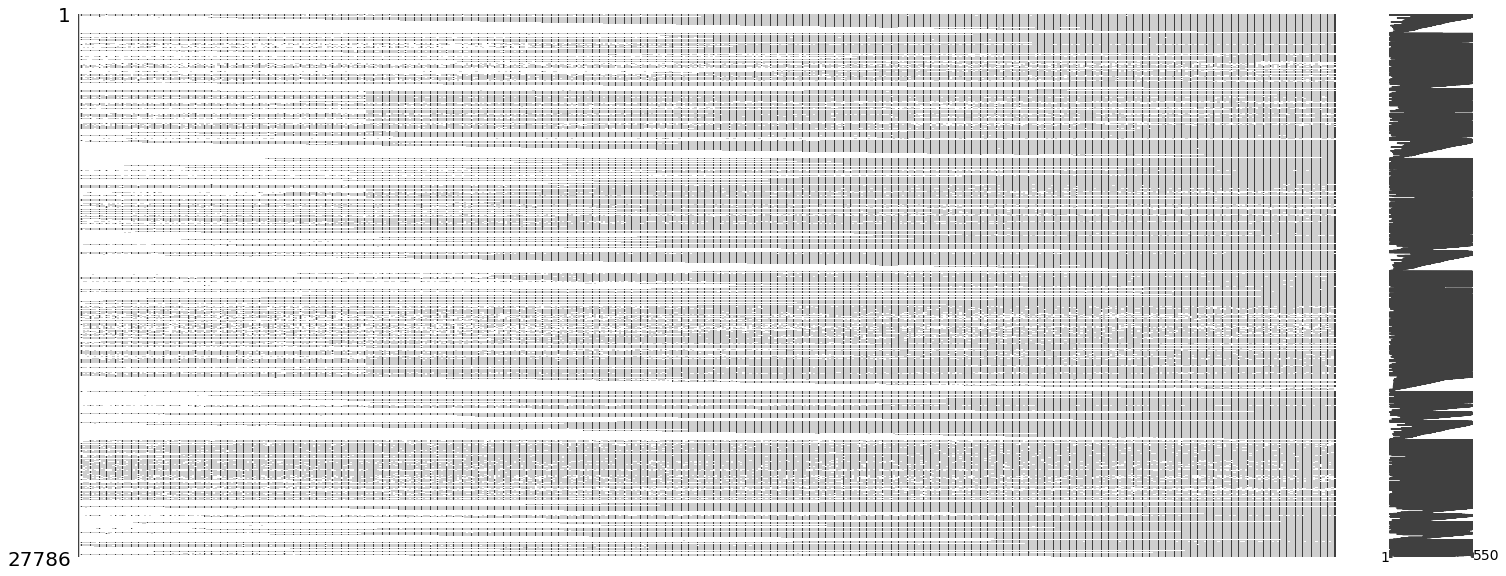

In [43]:
# Missing pattern is non-monotone, which is hard to deal with, so drop them.
msno.matrix(empty_sample)

In [44]:
# After dropping missing data, we still have 117277 samples.
df_cleaned=train.dropna()
df_cleaned.shape

(117277, 551)

## Simple EDA

In [45]:
# split the Page name
import re

def breakdown_topic(str):
    m = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if m is not None:
        return m.group(1), m.group(2), m.group(3), m.group(4)
    else:
        return "", "", "", ""

print(breakdown_topic("王嘉爾_zh.wikipedia.org_all-access_spider"))
print(breakdown_topic("金俊秀_zh.wikipedia.org_all-access_spider"))
print(breakdown_topic("Jean-Claude_Van_Damme_fr.wikipedia.org_desktop_all-agents"))

('王嘉爾', 'zh', 'all-access', 'spider')
('金俊秀', 'zh', 'all-access', 'spider')
('Jean-Claude_Van_Damme', 'fr', 'desktop', 'all-agents')


In [46]:
page_details = df_cleaned.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')
page_details[0:10]

,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
5,5566,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider
11,Ahq_e-Sports_Club,zh,all-access,spider
12,All_your_base_are_belong_to_us,zh,all-access,spider


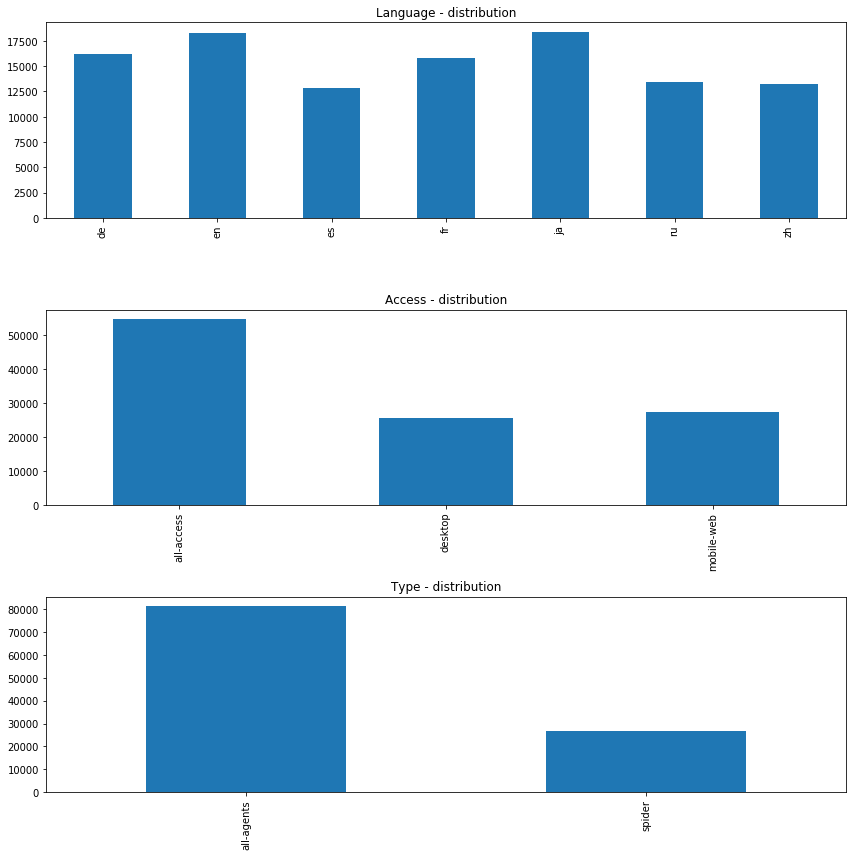

In [47]:
# The distribution of Language, Access and Type.
fig, axs  = plt.subplots(3,1,figsize=(12,12))

page_details["lang"].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Language - distribution')

page_details["access"].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Access - distribution')

page_details["type"].value_counts().sort_index().plot.bar(ax=axs[2])
axs[2].set_title('Type - distribution')

plt.tight_layout()

In [48]:
result = pd.concat([page_details, df_cleaned], axis=1, sort=False)
result.head()

,topic,lang,access,type,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access,spider,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh,all-access,spider,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh,all-access,spider,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh,all-access,spider,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566,zh,all-access,spider,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


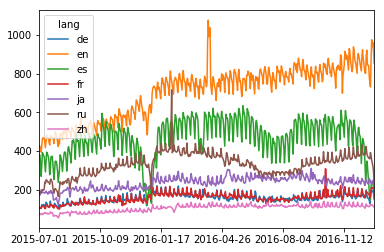

In [49]:
# obvious difference in language
groupby=result.groupby('lang').median()
groupby.T.plot()

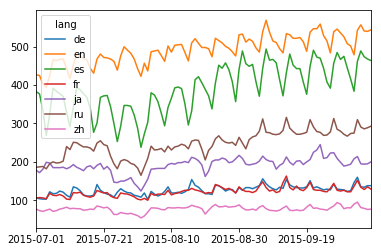

In [50]:
# obvious cyclicity in data by each week.
groupby.iloc[:,0:100].T.plot()

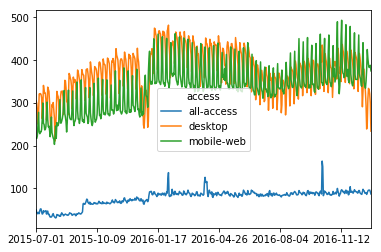

In [51]:
# obvious difference in type of access
groupby=result.groupby('access').median()
groupby.T.plot()

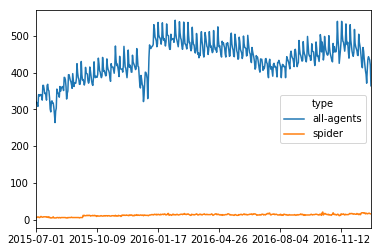

In [52]:
# obvious difference in type of agents
groupby=result.groupby('type').median()
groupby.T.plot()

## Modeling


###  RNN

In [53]:
model=df_cleaned.drop('Page',axis = 1)
row = model.iloc[20,:].values
X = row[0:549]
y = row[1:550]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.22, random_state = 0)


# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

#Training LSTM

#Reshaping Array
X_train = np.reshape(X_train, (X_train.shape[0],1,1))

# Importing the Keras libraries and packages for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM,RNN
from tensorflow.keras.optimizers import RMSprop

gru = Sequential()
gru.add(layers.SimpleRNN(128,activation = 'relu',return_sequences=True,input_shape=(None,1)))
gru.add(layers.Dense(1))
gru.compile(optimizer=RMSprop(), loss='mae')


# Fitting the RNN to the Training set

history = gru.fit(X_train, y_train,
                    epochs=30,
                    batch_size=300,
                    validation_split=0.2)




Train on 342 samples, validate on 86 samples
Epoch 1/30
342/342 [==============================] - 0s 1ms/sample - loss: 0.0746 - val_loss: 0.0603
Epoch 2/30
342/342 [==============================] - 0s 26us/sample - loss: 0.0665 - val_loss: 0.0582
Epoch 3/30
342/342 [==============================] - 0s 24us/sample - loss: 0.0647 - val_loss: 0.0571
Epoch 4/30
342/342 [==============================] - 0s 24us/sample - loss: 0.0638 - val_loss: 0.0568
Epoch 5/30
342/342 [==============================] - 0s 24us/sample - loss: 0.0633 - val_loss: 0.0555
Epoch 6/30
342/342 [==============================] - 0s 23us/sample - loss: 0.0624 - val_loss: 0.0549
Epoch 7/30
342/342 [==============================] - 0s 23us/sample - loss: 0.0619 - val_loss: 0.0551
Epoch 8/30
342/342 [==============================] - 0s 27us/sample - loss: 0.0618 - val_loss: 0.0549
Epoch 9/30
342/342 [==============================] - 0s 23us/sample - loss: 0.0620 - val_loss: 0.0541
Epoch 10/30
342/342 [========

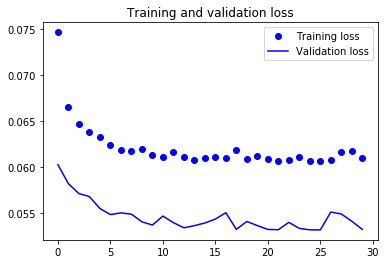

In [54]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
#rcParams['figure.figsize'] = 10, 6

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [83]:
y_test.shape

(121,)

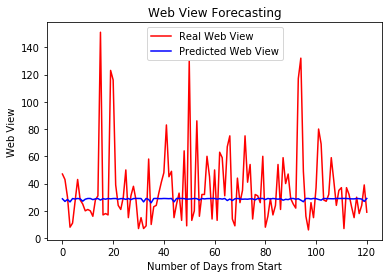

In [55]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (inputs.shape[0],1,1))
y_pred = gru.predict(inputs)
y_pred=np.reshape(y_pred, (inputs.shape[0],1))
y_pred = sc.inverse_transform(y_pred)

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

In [56]:
mse = ((y_pred - y_test) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 827.75
The Root Mean Squared Error of our forecasts is 28.77


## Advanced Simple RNN

In [57]:
gru = Sequential()
gru.add(layers.SimpleRNN(128,activation = 'relu',return_sequences=True,input_shape=(None,1)))#
gru.add(layers.SimpleRNN(64, activation='relu',return_sequences=True))
gru.add(layers.Dense(100,activation='relu'))
gru.add(layers.SimpleRNN(32, activation='relu'))
gru.add(layers.Dense(10,activation='relu'))
gru.add(layers.Dense(1))
gru.compile(optimizer='adam', loss='mae')

# Fitting the RNN to the Training set

history = gru.fit(X_train, y_train,
                    epochs=30,
                    batch_size=300,
                    validation_split=0.2)

Train on 342 samples, validate on 86 samples
Epoch 1/30
342/342 [==============================] - 1s 2ms/sample - loss: 0.0827 - val_loss: 0.0570
Epoch 2/30
342/342 [==============================] - 0s 41us/sample - loss: 0.0645 - val_loss: 0.0532
Epoch 3/30
342/342 [==============================] - 0s 37us/sample - loss: 0.0581 - val_loss: 0.0571
Epoch 4/30
342/342 [==============================] - 0s 37us/sample - loss: 0.0609 - val_loss: 0.0603
Epoch 5/30
342/342 [==============================] - 0s 36us/sample - loss: 0.0632 - val_loss: 0.0589
Epoch 6/30
342/342 [==============================] - 0s 37us/sample - loss: 0.0619 - val_loss: 0.0555
Epoch 7/30
342/342 [==============================] - 0s 36us/sample - loss: 0.0597 - val_loss: 0.0536
Epoch 8/30
342/342 [==============================] - 0s 37us/sample - loss: 0.0585 - val_loss: 0.0530
Epoch 9/30
342/342 [==============================] - 0s 36us/sample - loss: 0.0584 - val_loss: 0.0530
Epoch 10/30
342/342 [========

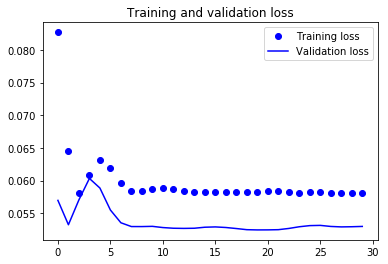

In [58]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
#rcParams['figure.figsize'] = 10, 6

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

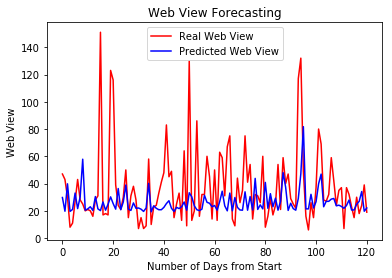

In [59]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (inputs.shape[0],1,1))
y_pred = gru.predict(inputs)
y_pred=np.reshape(y_pred, (inputs.shape[0],1))
y_pred = sc.inverse_transform(y_pred)

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

In [60]:
mse = ((y_pred - y_test) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 942.95
The Root Mean Squared Error of our forecasts is 30.71


### LSTM

In [61]:
from tensorflow.keras import optimizers
# Initialising the lstm
regressor = Sequential()

# Adding the input layerand the LSTM layer

regressor.add(LSTM(units = 256, activation = 'relu', input_shape = (None, 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = optimizers.RMSprop(lr=0.01), loss = 'mse')

history = regressor.fit(X_train, y_train,
                    epochs=100,
                    batch_size=300,
                    validation_split=0.2)



W0515 16:55:49.782099 140016186001216 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f54e35c3080>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Train on 342 samples, validate on 86 samples
Epoch 1/100
342/342 [==============================] - 1s 3ms/sample - loss: 0.0202 - val_loss: 0.0069
Epoch 2/100
342/342 [==============================] - 0s 44us/sample - loss: 0.0127 - val_loss: 0.0054
Epoch 3/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0106 - val_loss: 0.0054
Epoch 4/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0107 - val_loss: 0.0068
Epoch 5/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0126 - val_loss: 0.0054
Epoch 6/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0106 - val_loss: 0.0065
Epoch 7/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0109 - val_loss: 0.0059
Epoch 8/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0105 - val_loss: 0.0057
Epoch 9/100
342/342 [==============================] - 0s 39us/sample - loss: 0.0113 - val_loss: 0.0060
Epoch 10/100
342/342

342/342 [==============================] - 0s 40us/sample - loss: 0.0104 - val_loss: 0.0054
Epoch 79/100
342/342 [==============================] - 0s 39us/sample - loss: 0.0105 - val_loss: 0.0054
Epoch 80/100
342/342 [==============================] - 0s 39us/sample - loss: 0.0105 - val_loss: 0.0054
Epoch 81/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0106 - val_loss: 0.0054
Epoch 82/100
342/342 [==============================] - 0s 40us/sample - loss: 0.0105 - val_loss: 0.0070
Epoch 83/100
342/342 [==============================] - 0s 43us/sample - loss: 0.0109 - val_loss: 0.0058
Epoch 84/100
342/342 [==============================] - 0s 42us/sample - loss: 0.0112 - val_loss: 0.0059
Epoch 85/100
342/342 [==============================] - 0s 43us/sample - loss: 0.0105 - val_loss: 0.0057
Epoch 86/100
342/342 [==============================] - 0s 42us/sample - loss: 0.0112 - val_loss: 0.0057
Epoch 87/100
342/342 [==============================] - 0s 43us/samp

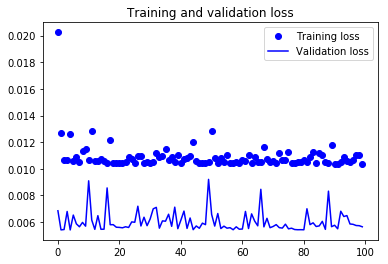

In [62]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
#rcParams['figure.figsize'] = 10, 6

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

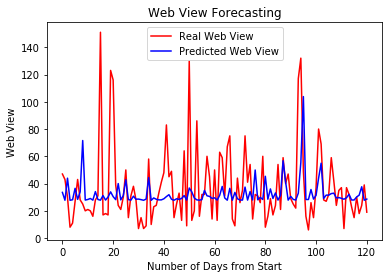

In [63]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (inputs.shape[0], 1, 1))
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)
#rcParams['figure.figsize'] = 18, 8

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()



In [64]:
mse = ((y_pred - y_test) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 866.92
The Root Mean Squared Error of our forecasts is 29.44


## Modification on LSTM

In [65]:
from tensorflow.keras import optimizers
# Initialising the lstm
regressor = Sequential()

# Adding the input layerand the LSTM layer
regressor.add(LSTM(units = 128, activation = 'linear', return_sequences=True,input_shape = (None, 1)))
regressor.add(LSTM(units = 64, activation = 'linear'))
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mse')

# Fitting the RNN to the Training set

history = regressor.fit(X_train, y_train,
                    epochs=25,
                    batch_size=300,
                    validation_split=0.2)

W0515 16:55:54.158684 140016186001216 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f54e19cf588>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0515 16:55:54.307053 140016186001216 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f54e19cfc88>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Train on 342 samples, validate on 86 samples
Epoch 1/25
342/342 [==============================] - 2s 5ms/sample - loss: 0.0202 - val_loss: 0.0117
Epoch 2/25
342/342 [==============================] - 0s 70us/sample - loss: 0.0185 - val_loss: 0.0103
Epoch 3/25
342/342 [==============================] - 0s 63us/sample - loss: 0.0169 - val_loss: 0.0091
Epoch 4/25
342/342 [==============================] - 0s 63us/sample - loss: 0.0155 - val_loss: 0.0079
Epoch 5/25
342/342 [==============================] - 0s 62us/sample - loss: 0.0142 - val_loss: 0.0070
Epoch 6/25
342/342 [==============================] - 0s 62us/sample - loss: 0.0130 - val_loss: 0.0062
Epoch 7/25
342/342 [==============================] - 0s 63us/sample - loss: 0.0121 - val_loss: 0.0057
Epoch 8/25
342/342 [==============================] - 0s 63us/sample - loss: 0.0114 - val_loss: 0.0055
Epoch 9/25
342/342 [==============================] - 0s 62us/sample - loss: 0.0109 - val_loss: 0.0055
Epoch 10/25
342/342 [========

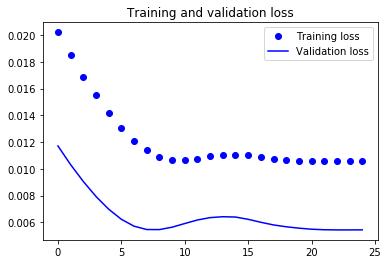

In [66]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
#rcParams['figure.figsize'] = 10, 6

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

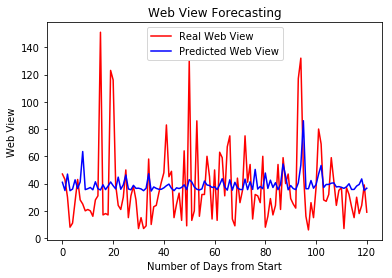

In [67]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (inputs.shape[0], 1, 1))
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)
#rcParams['figure.figsize'] = 18, 8

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()



In [68]:
mse = ((y_pred - y_test) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 805.19
The Root Mean Squared Error of our forecasts is 28.38


## ARIMA

Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [69]:
from pylab import rcParams
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 18, 8



In [70]:
model= df_cleaned.drop('Page',axis = 1)
df = model.transpose()
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['index'])
df = df.set_index('Date')
df

,index,0,1,2,3,5,7,8,9,11,...,144939,144940,144941,144942,144943,144944,144945,144946,144947,144948
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,2015-07-01,18.0,11.0,1.0,35.0,12.0,118.0,5.0,6.0,2.0,...,4.0,21.0,23.0,3.0,1.0,8.0,29.0,4.0,0.0,3.0
2015-07-02,2015-07-02,11.0,14.0,0.0,13.0,7.0,26.0,23.0,3.0,1.0,...,3.0,32.0,40.0,7.0,3.0,13.0,16.0,25.0,2.0,10.0
2015-07-03,2015-07-03,5.0,15.0,1.0,10.0,4.0,30.0,14.0,5.0,4.0,...,4.0,38.0,55.0,6.0,8.0,19.0,6.0,7.0,6.0,41.0
2015-07-04,2015-07-04,13.0,18.0,1.0,94.0,5.0,24.0,12.0,12.0,4.0,...,17.0,21.0,32.0,3.0,3.0,14.0,11.0,11.0,6.0,17.0
2015-07-05,2015-07-05,14.0,11.0,0.0,4.0,20.0,29.0,9.0,6.0,2.0,...,28.0,28.0,42.0,3.0,6.0,6.0,33.0,6.0,7.0,16.0
2015-07-06,2015-07-06,9.0,13.0,4.0,26.0,8.0,127.0,9.0,5.0,6.0,...,11.0,17.0,21.0,5.0,37.0,5.0,4.0,6.0,5.0,14.0
2015-07-07,2015-07-07,9.0,22.0,0.0,14.0,5.0,53.0,35.0,4.0,3.0,...,9.0,22.0,30.0,5.0,22.0,10.0,11.0,16.0,4.0,8.0
2015-07-08,2015-07-08,22.0,11.0,3.0,9.0,17.0,37.0,15.0,13.0,6.0,...,12.0,18.0,17.0,1.0,75.0,9.0,16.0,11.0,6.0,12.0
2015-07-09,2015-07-09,26.0,10.0,4.0,11.0,24.0,20.0,14.0,9.0,9.0,...,9.0,29.0,26.0,8.0,13.0,5.0,10.0,23.0,7.0,4.0


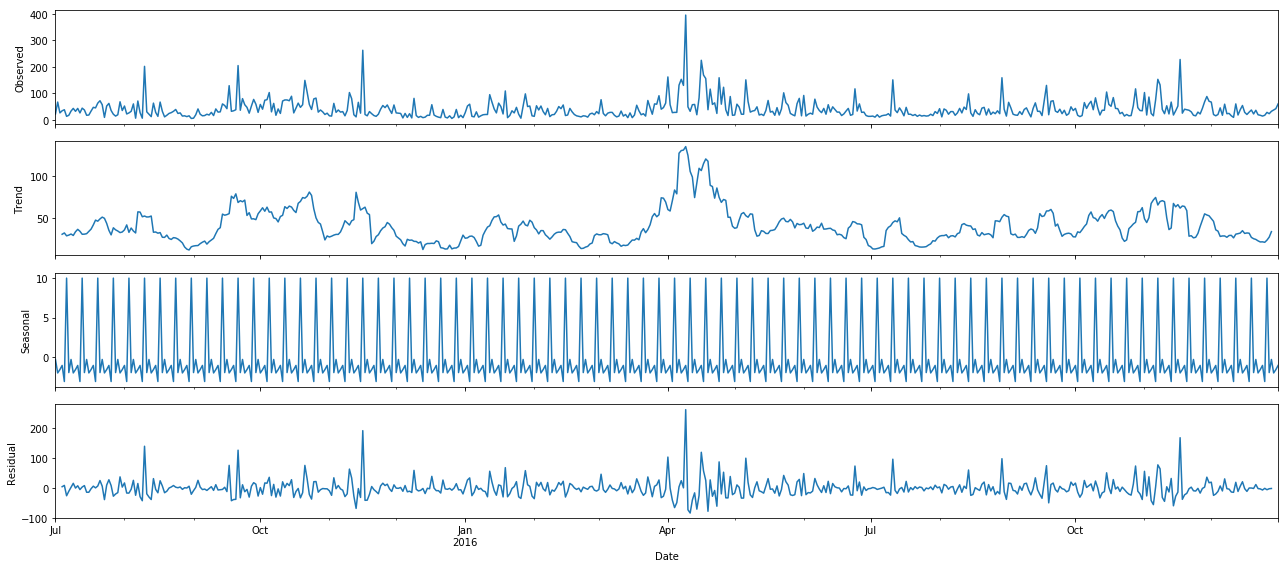

In [71]:
y=df[26]
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [72]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [73]:
# grid search 
aic=[]
param_lst=[]
param_seasonal_lst=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            aic.append(results.aic)
            param_lst.append(param)
            param_seasonal_lst.append(param_seasonal)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5962.267302933984
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5712.267173203716
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:5736.599608242324
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:5340.6834441644
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:5623.551413227904
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:5462.3103418388055
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:5511.036703325941
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:5341.542318068923
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5786.608416393983
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5605.994738532225
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5714.914293170894
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5309.490014549278
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5580.702642542571
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5430.039527347622
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5494.625398779316
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5310.888924542909
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5747.784011758157
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5634.10715721467
ARIMA(0, 1, 

In [74]:
arm=np.argmin(aic)
print(param_lst[arm],param_seasonal_lst[arm],aic[arm])

(1, 1, 1) (0, 1, 1, 12) 5277.762947176978


In [75]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=param_lst[arm],
                                seasonal_order=param_seasonal_lst[arm],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0813      0.044      1.840      0.066      -0.005       0.168
ma.L1         -0.9001      0.019    -48.398      0.000      -0.937      -0.864
ma.S.L12      -1.0000     92.976     -0.011      0.991    -183.230     181.230
sigma2      1294.3017    1.2e+05      0.011      0.991   -2.35e+05    2.37e+05


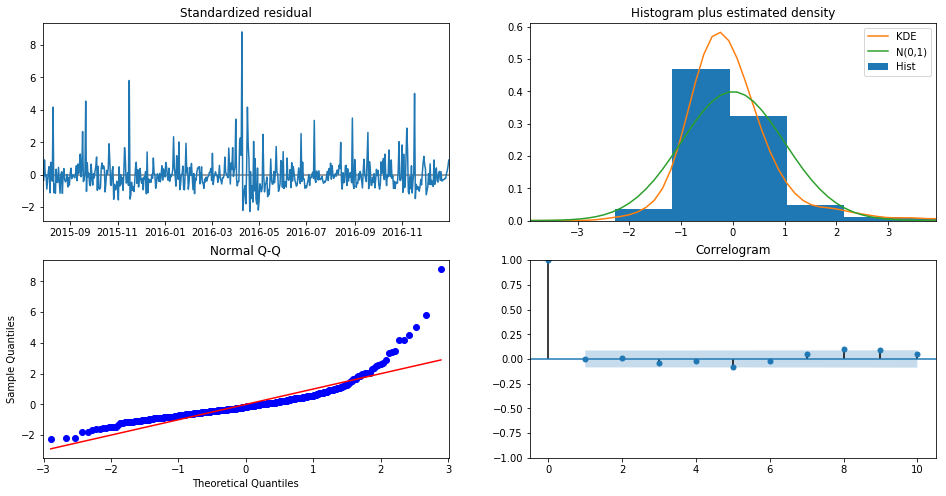

In [76]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

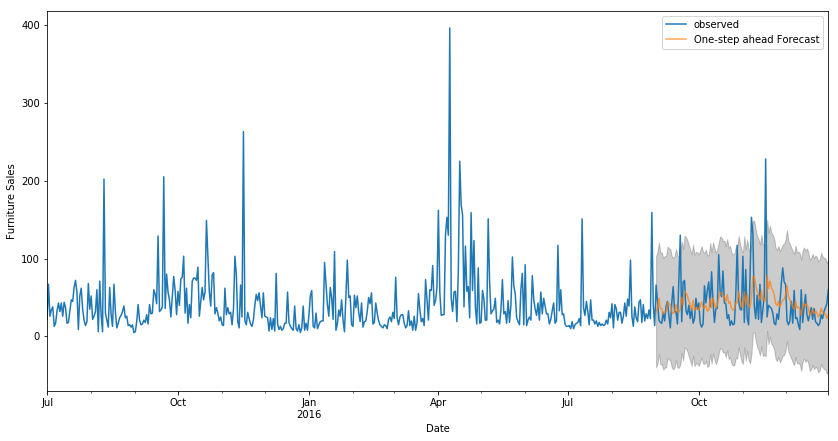

In [77]:
pred = results.get_prediction(start=pd.to_datetime('2016-09-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [78]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-09-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1070.51
The Root Mean Squared Error of our forecasts is 32.72


## Simple Conclusion
LSTM holds the best performance. The worse performance of Time series may due to the in-obvious pattern of trend, which need to be carefully developed in future with the information of page name, language, access type. 